# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from skimage import exposure
from skimage.restoration import denoise_bilateral
from sklearn.decomposition import PCA

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from torchvision import datasets

## **Configurazione**

In [2]:
@dataclass
class Config:
    # paths
    fit_dir  = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid"
    #fit_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/valid"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test_degradato"
    
    img_size = 128   # per HOG spesso 128 va benissimo
    random_state = 42 # tuning
    max_iter = 50000 # tuning
    
def sanity_check_paths(cfg: Config):
    for p in [cfg.fit_dir, cfg.test_dir]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Path not found: {p}")
    print("OK paths")
    print("fit_dir:", cfg.fit_dir)
    print("test_dir:", cfg.test_dir)

## **Feature Extraction**

In [3]:
# =========================
# Pyramid splitting
# =========================
def split_2x2(gray: np.ndarray) -> List[np.ndarray]:
    H, W = gray.shape
    h2, w2 = H // 2, W // 2
    return [
        gray[0:h2,   0:w2],   # TL
        gray[0:h2,   w2:W],   # TR
        gray[h2:H,   0:w2],   # BL
        gray[h2:H,   w2:W],   # BR
    ]


# =========================
# HOG Pyramid (1x1 + 2x2)
# =========================
def hog_feat(gray: np.ndarray, hog_conf: Dict[str, Any]) -> np.ndarray:
    return hog(
        gray,
        orientations=hog_conf["orient"],
        pixels_per_cell=hog_conf["ppc"],
        cells_per_block=hog_conf["cpb"],
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)


def extract_hog_pyramid(gray: np.ndarray, hog_conf: Dict[str, Any]) -> np.ndarray:
    feats = [hog_feat(gray, hog_conf)]
    for p in split_2x2(gray):
        feats.append(hog_feat(p, hog_conf))
    return np.concatenate(feats, axis=0).astype(np.float32)


# =========================
# LBP Pyramid (1x1 + 2x2)
# =========================
def lbp_hist(gray: np.ndarray, P: int, R: int) -> np.ndarray:
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    return hist


def extract_lbp_pyramid(gray: np.ndarray, P: int, R: int) -> np.ndarray:
    feats = [lbp_hist(gray, P=P, R=R)]
    for p in split_2x2(gray):
        feats.append(lbp_hist(p, P=P, R=R))
    return np.concatenate(feats, axis=0).astype(np.float32)


# =========================
# Full feature: HOG pyr + LBP pyr
# =========================
def extract_feature(path: str, cfg: Config, hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> np.ndarray:
    img = Image.open(path).convert("RGB").resize((cfg.img_size, cfg.img_size))
    gray = np.array(img.convert("L"))  # uint8

    hog_pyr = extract_hog_pyramid(gray, hog_conf)
    lbp_pyr = extract_lbp_pyramid(gray, P=lbp_conf["P"], R=lbp_conf["R"])

    return np.concatenate([hog_pyr, lbp_pyr], axis=0).astype(np.float32)


def build_xy(folder, cfg: Config, hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for path, label in folder.samples:
        X.append(extract_feature(path, cfg, hog_conf, lbp_conf))
        y.append(label)
    return np.array(X), np.array(y)


# =========================
# Model
# =========================
def build_model(C: float, pca_n: int, solver: str="lbfgs", class_weight=None) -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_n, random_state=42)),
        ("clf", LogisticRegression(
            max_iter=5000,
            C=C,
            solver=solver,
            class_weight=class_weight
        ))
    ])


## **Utils**

In [4]:
def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 30):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")


def plot_cm(cm: np.ndarray, title: str):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## **Migliori configurazioni**

In [ ]:
# Base: prendo la migliore: HOG orient=16 + LBP P32 R4
HOG_CONF = dict(orient=16, ppc=(16, 16), cpb=(2, 2))
LBP_CONF = dict(P=32, R=4)

BEST_CONFIGS = [
    dict(tag="PCA480 C=8  lbfgs",   C=8.0,  solver="lbfgs", class_weight=None),
    dict(tag="PCA480 C=8  saga",    C=8.0,  solver="saga",  class_weight=None),
    dict(tag="PCA480 C=8  saga+bal",C=8.0,  solver="saga",  class_weight="balanced"),
    dict(tag="PCA480 C=10 saga+bal",C=10.0, solver="saga",  class_weight="balanced"),
]


## **Main**

In [6]:
cfg = Config()
np.random.seed(cfg.random_state)
sanity_check_paths(cfg)

OK paths
fit_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid
test_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato


In [7]:
fit_ds  = datasets.ImageFolder(cfg.fit_dir)
test_ds = datasets.ImageFolder(cfg.test_dir)

assert fit_ds.classes == test_ds.classes, "Class order diverso tra fit e test!"
class_names = fit_ds.classes

print("Num classes:", len(class_names))
print("Fit samples:", len(fit_ds))
print("Test samples:", len(test_ds))

Num classes: 100
Fit samples: 500
Test samples: 500


In [ ]:
# migliori parametri trovati
HOG_CONF = dict(orient=16, ppc=(16, 16), cpb=(2, 2))
LBP_CONF = dict(P=32, R=4)

print("\n[FEATURE] Estrazione feature (fit)...")
X_fit, y_fit = build_xy(fit_ds, cfg, HOG_CONF, LBP_CONF)
print("[FEATURE] Estrazione feature (test)...")
X_test, y_test = build_xy(test_ds, cfg, HOG_CONF, LBP_CONF)

print("X_fit shape:", X_fit.shape, "| X_test shape:", X_test.shape)


[FEATURE] Estrazione feature (fit)...
[FEATURE] Estrazione feature (test)...
X_fit shape: (500, 5610) | X_test shape: (500, 5610)



RUN: PCA480 C=8  lbfgs
Accuracy:        0.2060
Macro-F1:        0.1970
Macro-Precision: 0.2285
Macro-Recall:    0.2060


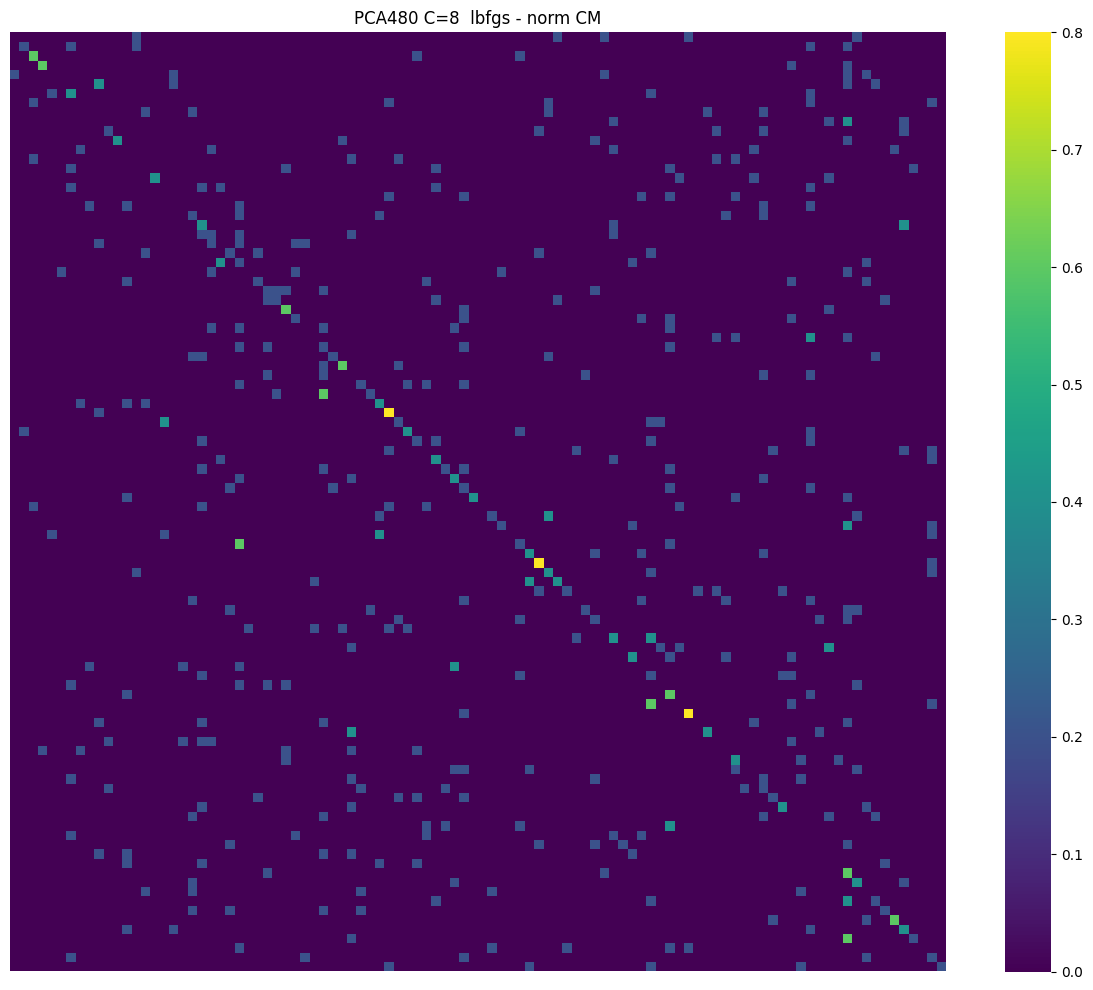


=== Top confusions: PCA480 C=8  lbfgs ===

Top 30 coppie più confuse:

hang gliding → frisbee  | 3 errori
log rolling → disc golf  | 3 errori
rugby → roller derby  | 3 errori
weightlifting → trapeze  | 3 errori
balance beam → baton twirling  | 2 errori
baton twirling → trapeze  | 2 errori
chuckwagon racing → water polo  | 2 errori
disc golf → croquet  | 2 errori
formula 1 racing → swimming  | 2 errori
hockey → bull riding  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
lacrosse → harness racing  | 2 errori
nascar racing → luge  | 2 errori
polo → roller derby  | 2 errori
pommel horse → tennis  | 2 errori
rock climbing → ice climbing  | 2 errori
shuffleboard → golf  | 2 errori
surfing → rowing  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → bobsled  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
a

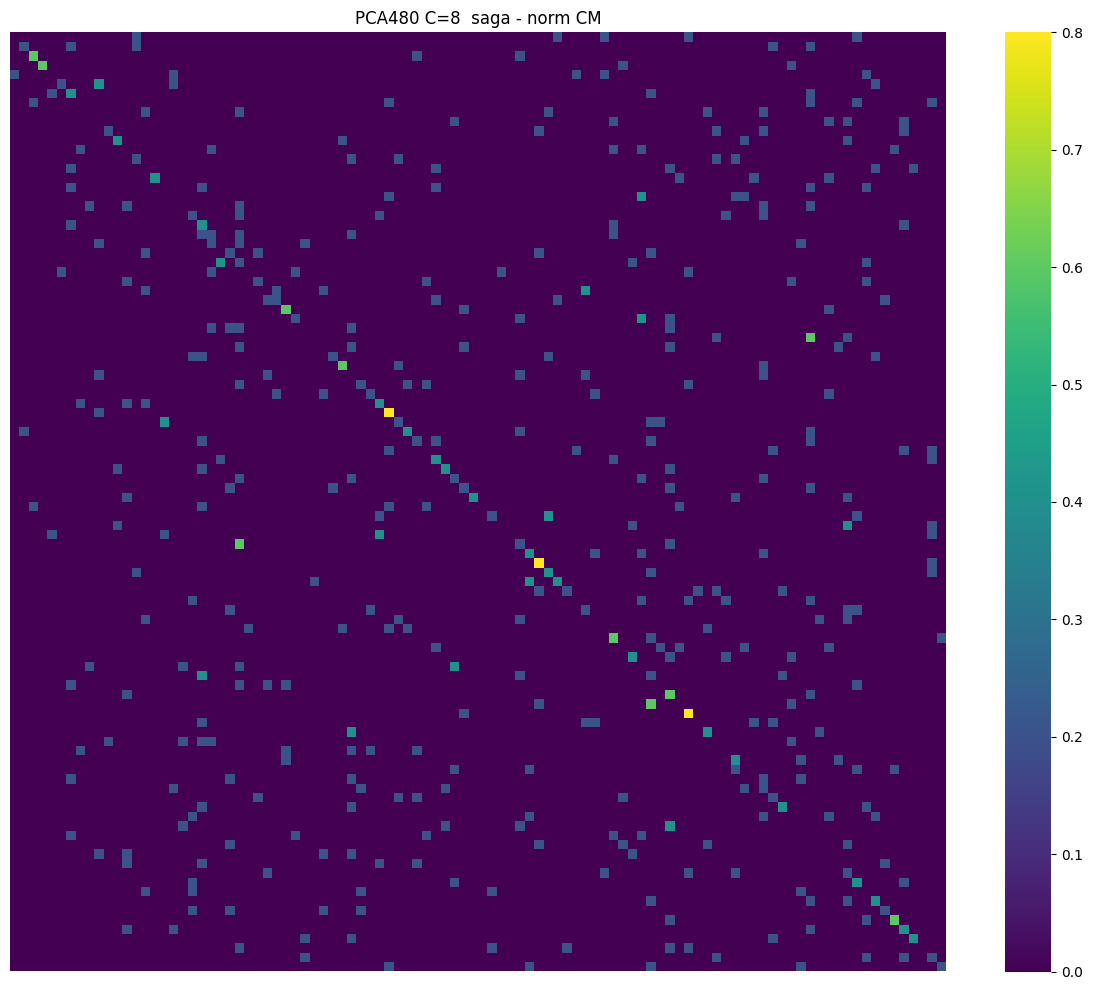


=== Top confusions: PCA480 C=8  saga ===

Top 30 coppie più confuse:

formula 1 racing → swimming  | 3 errori
log rolling → disc golf  | 3 errori
rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
bungee jumping → rock climbing  | 2 errori
disc golf → croquet  | 2 errori
figure skating men → pole climbing  | 2 errori
fly fishing → rock climbing  | 2 errori
hockey → bull riding  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
lacrosse → harness racing  | 2 errori
nascar racing → luge  | 2 errori
rock climbing → ice climbing  | 2 errori
roller derby → chuckwagon racing  | 2 errori
shuffleboard → golf  | 2 errori
surfing → rowing  | 2 errori
air hockey → bobsled  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → bobsled  | 1 errori
ampute football → speed skating  | 1 err

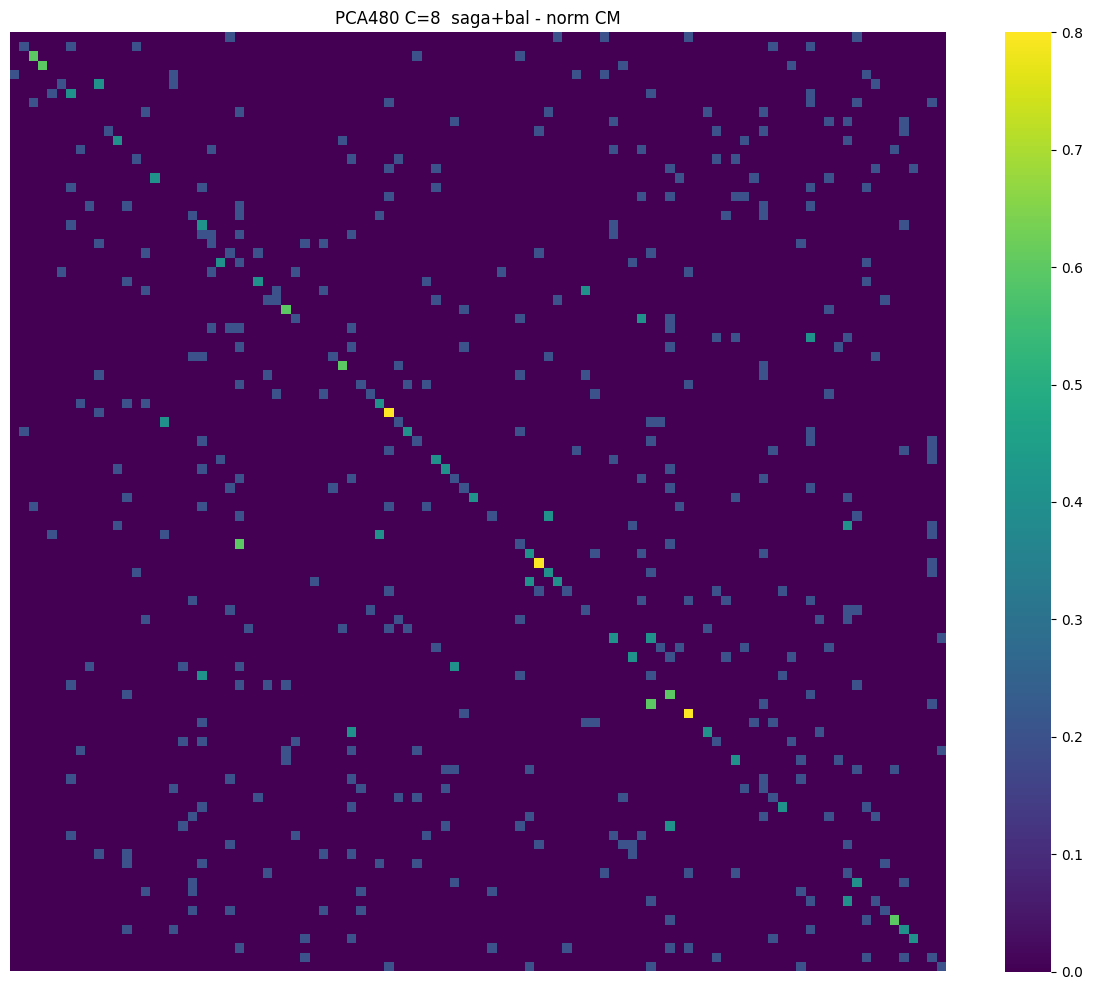


=== Top confusions: PCA480 C=8  saga+bal ===

Top 30 coppie più confuse:

log rolling → disc golf  | 3 errori
rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
disc golf → croquet  | 2 errori
figure skating men → pole climbing  | 2 errori
fly fishing → rock climbing  | 2 errori
formula 1 racing → swimming  | 2 errori
hockey → bull riding  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
lacrosse → harness racing  | 2 errori
nascar racing → luge  | 2 errori
polo → roller derby  | 2 errori
rock climbing → ice climbing  | 2 errori
roller derby → chuckwagon racing  | 2 errori
shuffleboard → golf  | 2 errori
surfing → rowing  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → curling  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → bobsled  | 1 errori
ampute footba

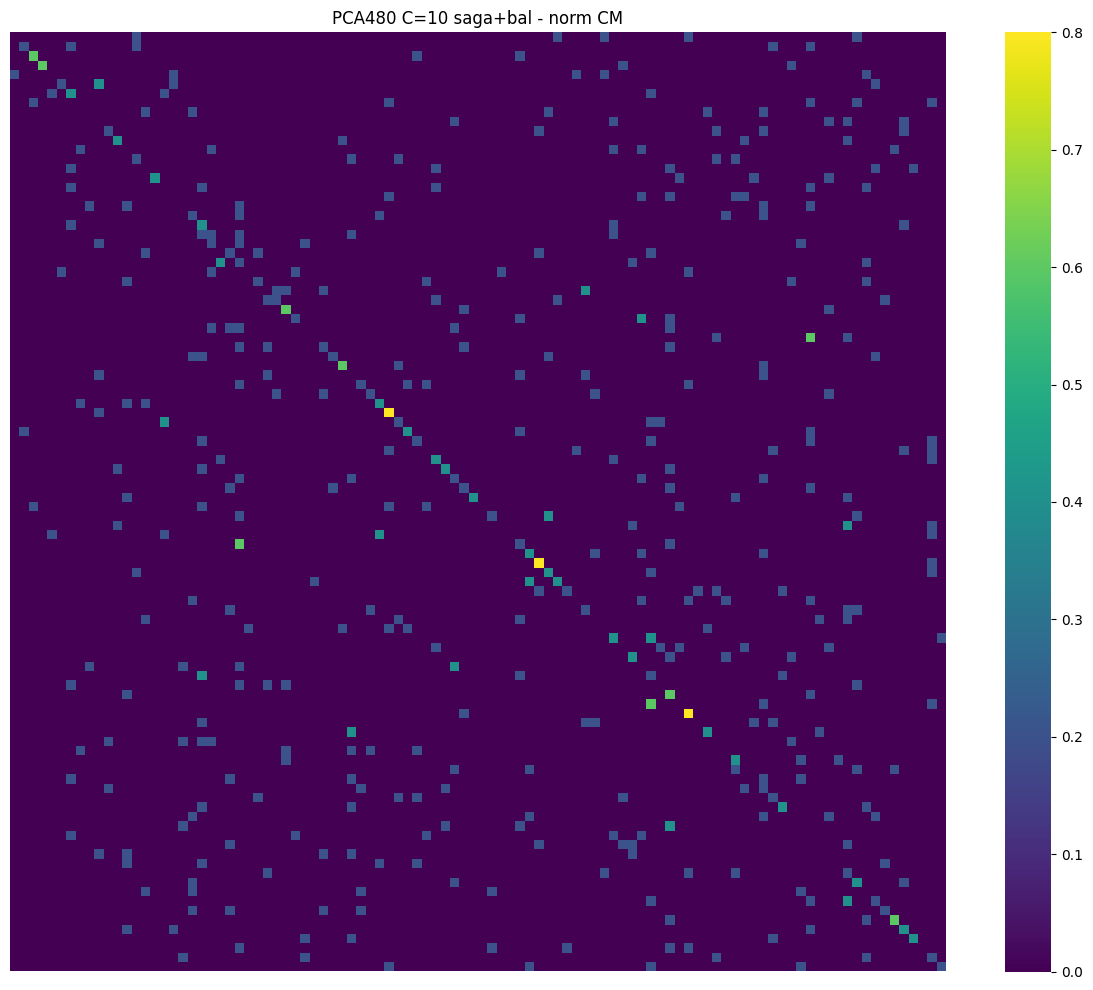


=== Top confusions: PCA480 C=10 saga+bal ===

Top 30 coppie più confuse:

formula 1 racing → swimming  | 3 errori
log rolling → disc golf  | 3 errori
rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
disc golf → croquet  | 2 errori
figure skating men → pole climbing  | 2 errori
fly fishing → rock climbing  | 2 errori
hockey → bull riding  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
lacrosse → harness racing  | 2 errori
nascar racing → luge  | 2 errori
polo → roller derby  | 2 errori
rock climbing → ice climbing  | 2 errori
roller derby → chuckwagon racing  | 2 errori
shuffleboard → golf  | 2 errori
surfing → rowing  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → bobsled  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → bobsled  | 1 errori
ampute footba

In [ ]:
PCA_N = 480

all_results = {}
cms = {}

for conf in BEST_CONFIGS:
    print("\n" + "="*60)
    print(f"RUN: {conf['tag']}")
    print("="*60)

    model = build_model(
        C=conf["C"],
        pca_n=PCA_N,
        solver=conf["solver"],
        class_weight=conf["class_weight"]
    )

    model.fit(X_fit, y_fit)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro", zero_division=0)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)

    print(f"Accuracy:        {acc:.4f}")
    print(f"Macro-F1:        {f1:.4f}")
    print(f"Macro-Precision: {prec:.4f}")
    print(f"Macro-Recall:    {rec:.4f}")

    all_results[conf["tag"]] = {
        "acc": acc,
        "f1": f1,
        "prec": prec,
        "rec": rec,
        "C": conf["C"],
        "solver": conf["solver"],
        "class_weight": conf["class_weight"]
    }
    cms[conf["tag"]] = cm

    # CM e confusions per ogni run:
    plot_cm(cm, title=f"{conf['tag']} - norm CM")
    print(f"\n=== Top confusions: {conf['tag']} ===")
    print_top_confusions(cm, class_names, top_k=30)

In [ ]:
print("\n" + "="*60)
print("FINAL SUMMARY (SPHOG + SP-LBP)")
print("="*60)

# stampo ordinato per performance
for tag, d in sorted(all_results.items(), key=lambda x: x[1]["f1"], reverse=True):
    print(
        f"{tag:30} | "
        f"Acc={d['acc']:.4f} | "
        f"F1={d['f1']:.4f} | "
        f"P={d['prec']:.4f} | "
        f"R={d['rec']:.4f} | "
        f"C={d['C']} | "
        f"solver={d['solver']} | "
        f"cw={d['class_weight']}"
    )


FINAL SUMMARY (SPHOG + SP-LBP)
PCA480 C=8  lbfgs              | Acc=0.2060 | F1=0.1970 | P=0.2285 | R=0.2060 | C=8.0 | solver=lbfgs | cw=None
PCA480 C=8  saga+bal           | Acc=0.2040 | F1=0.1956 | P=0.2208 | R=0.2040 | C=8.0 | solver=saga | cw=balanced
PCA480 C=8  saga               | Acc=0.2040 | F1=0.1945 | P=0.2147 | R=0.2040 | C=8.0 | solver=saga | cw=None
PCA480 C=10 saga+bal           | Acc=0.2020 | F1=0.1934 | P=0.2133 | R=0.2020 | C=10.0 | solver=saga | cw=balanced


In [11]:
y_fit_pred = model.predict(X_fit)

acc_fit = accuracy_score(y_fit, y_fit_pred)
f1_fit = f1_score(y_fit, y_fit_pred, average="macro")

print("FIT Accuracy:", acc_fit)
print("FIT F1:", f1_fit)


FIT Accuracy: 1.0
FIT F1: 1.0


## **Conclusione** 

il miglior modello:
- SPHOG (1x1+2x2) + SP-LBP (1x1+2x2)
- PCA = 480–499
- C = 8
- solver = lbfgs

con performance:

- Accuracy = 0.2060
- Macro Precision = 0.2285
- Macro Recall = 0.2060
- Macro-F1 = 0.1970